In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [3]:
device = torch.device("cuda:1")
# device = torch.device("cpu")

## MNIST dataset

In [4]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [5]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [6]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [7]:
input_size = 784
output_size = 10

In [8]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [9]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [10]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [11]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        
#         self.centers = torch.randn(num_centers, input_dim)/3.
        self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
#         self.scaler = nn.Parameter(torch.Tensor([1.0]))
#         self.layernorm = nn.LayerNorm(num_centers, elementwise_affine=False)
        self.s = nn.Parameter(torch.zeros(1))
        self.t = nn.Parameter(torch.ones(1))
        self.data_dep_init_done = False
    
    def _initialize_data(self, x):
        print(f"Initializing inp shape {x.shape}")
        assert self.s is not None and self.t is not None # for now
        self.s.data[0] = (1/x.std()).detach()
        self.t.data[0] = (-x.mean()).detach()
        self.data_dep_init_done = True
        
    def forward(self, x):
#         x = x[:, :self.input_dim]
            
        dists = torch.cdist(x, self.centers)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

#         dists = self.layernorm(dists)

#         dists = torch.exp(-(dists**2) * self.scaler)
#         dists = torch.softmax(-dists*self.scaler, dim=1)


        if not self.data_dep_init_done:
            self._initialize_data(dists)
        dists = (dists + self.t) * self.s
#         dists = dists*self.s + self.t
        
        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

In [12]:
dt = DistanceTransform(784, 20)

In [13]:
dists = dt(torch.randn(2, 784))

Initializing inp shape torch.Size([2, 20])


In [14]:
dists.shape

torch.Size([2, 20])

In [15]:
dists.data

tensor([[-1.2505, -1.1631, -1.3666, -1.0543, -0.3841, -1.1841, -0.8957, -1.3768,
         -0.6185, -0.4190, -1.2532, -0.7086, -1.0072, -0.5846, -0.6883, -0.9974,
         -0.6336, -1.0941, -1.2070, -0.8838],
        [ 0.7168,  1.3274,  0.6694,  0.8052,  0.9278,  0.9943,  0.8013,  0.9596,
          0.4961,  0.8816,  0.2357,  0.4782,  1.4831,  1.2786,  0.9169,  1.1432,
          1.2856,  1.1076,  0.9675,  1.2944]])

In [16]:
dt.centers.shape

torch.Size([20, 784])

In [17]:
dt.set_centroid_to_data_randomly(train_loader)

In [18]:
# dt.set_centroid_to_data(train_loader)

In [19]:
### distance vs matrix multiplication time

In [20]:
N = 784
M = 784
A = torch.randn(N, M).to(device)

In [21]:
# torch.cdist(data, data)

In [22]:
%timeit torch.cdist(A, A)

435 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%timeit torch.matmul(A, A)

221 µs ± 533 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [24]:
#######################

In [25]:
model = nn.Sequential(
                DistanceTransform(784, 785),
#                 nn.BatchNorm1d(785),
                nn.LeakyReLU(),
                DistanceTransform(785, 200),
#                 nn.BatchNorm1d(200),
                nn.LeakyReLU(),
                DistanceTransform(200, 50),
#                 nn.BatchNorm1d(50),
                nn.LeakyReLU(),
                DistanceTransform(50, 10),
                nn.BatchNorm1d(10),
#                 nn.Linear(10, 10),
            )
model.to(device)

Sequential(
  (0): DistanceTransform()
  (1): LeakyReLU(negative_slope=0.01)
  (2): DistanceTransform()
  (3): LeakyReLU(negative_slope=0.01)
  (4): DistanceTransform()
  (5): LeakyReLU(negative_slope=0.01)
  (6): DistanceTransform()
  (7): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [26]:
# model[0].centers.requires_grad=False
# model[0].set_centroid_to_data_randomly(train_loader) ## this worked best for preserving locality
# model[0].set_centroid_to_data_maxdist(train_loader)

In [27]:
center_lbl = model(model[0].centers.data)
output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
torch.unique(output_cent, return_counts=True)

Initializing inp shape torch.Size([785, 785])
Initializing inp shape torch.Size([785, 200])
Initializing inp shape torch.Size([785, 50])
Initializing inp shape torch.Size([785, 10])


(tensor([3, 4, 5]), tensor([668, 107,  10]))

In [28]:
# model = nn.Sequential(
#                 nn.Linear(784, 785),
#                 nn.BatchNorm1d(785),
#                 nn.LeakyReLU(),
#                 nn.Linear(785, 200),
#                 nn.BatchNorm1d(200),
#                 nn.LeakyReLU(),
#                 nn.Linear(200, 50),
#                 nn.BatchNorm1d(50),
#                 nn.LeakyReLU(),
#                 nn.Linear(50, 10),
#                 nn.BatchNorm1d(10)
#             )
# model.to(device)

In [29]:
# model[0].weight.data = dt.centers.data.clone().to(device)/85.0

In [30]:
optimizer = optim.Adam(list(model.parameters()), 
                            lr=0.001)
criterion = nn.CrossEntropyLoss()

In [31]:
index = 0
train_accs, test_accs = [], []
for epoch in tqdm(list(range(40))):
    model.train()
    train_acc = 0
    train_count = 0
    for xx, yy in train_loader:
        xx, yy = xx.to(device), yy.to(device)
        yout = model(xx)
        loss = criterion(yout, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        train_acc += correct
        train_count += len(outputs)

    train_accs.append(float(train_acc)/train_count*100)
    train_acc = 0
    train_count = 0
    
#     if epoch%5 == 0:
#         print(f"Shifting the centroids to the nearest data point")
#         model[0].set_centroid_to_data(train_loader)

    print(f'Epoch: {epoch}:{index},  Loss:{float(loss)}')
    test_count = 0
    test_acc = 0
    model.eval()
    for xx, yy in test_loader:
        xx, yy = xx.to(device), yy.to(device)
        with torch.no_grad():
            yout = model(xx)
        outputs = torch.argmax(yout, dim=1).data.cpu().numpy()
        correct = (outputs == yy.data.cpu().numpy()).astype(float).sum()
        test_acc += correct
        test_count += len(xx)
    test_accs.append(float(test_acc)/test_count*100)
    print(f'Train Acc:{train_accs[-1]:.2f}%, Test Acc:{test_accs[-1]:.2f}%')
    print()

### after each class index is finished training
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0:0,  Loss:1.8244117498397827


  2%|▎         | 1/40 [00:03<02:28,  3.81s/it]

Train Acc:20.80%, Test Acc:23.49%

Epoch: 1:0,  Loss:1.7561907768249512


  5%|▌         | 2/40 [00:07<02:25,  3.83s/it]

Train Acc:26.35%, Test Acc:30.15%

Epoch: 2:0,  Loss:1.6284388303756714


  8%|▊         | 3/40 [00:11<02:23,  3.88s/it]

Train Acc:31.97%, Test Acc:37.81%

Epoch: 3:0,  Loss:1.3936840295791626


 10%|█         | 4/40 [00:15<02:19,  3.88s/it]

Train Acc:40.42%, Test Acc:41.27%

Epoch: 4:0,  Loss:1.330519437789917


 12%|█▎        | 5/40 [00:19<02:16,  3.91s/it]

Train Acc:45.97%, Test Acc:45.65%

Epoch: 5:0,  Loss:1.0837092399597168


 15%|█▌        | 6/40 [00:23<02:12,  3.89s/it]

Train Acc:49.75%, Test Acc:53.15%

Epoch: 6:0,  Loss:1.2730098962783813


 18%|█▊        | 7/40 [00:27<02:08,  3.89s/it]

Train Acc:52.02%, Test Acc:55.73%

Epoch: 7:0,  Loss:1.319447636604309


 20%|██        | 8/40 [00:31<02:04,  3.89s/it]

Train Acc:54.67%, Test Acc:56.81%

Epoch: 8:0,  Loss:1.155943751335144


 22%|██▎       | 9/40 [00:34<02:00,  3.89s/it]

Train Acc:56.43%, Test Acc:57.88%

Epoch: 9:0,  Loss:1.135108470916748


 25%|██▌       | 10/40 [00:38<01:56,  3.89s/it]

Train Acc:57.89%, Test Acc:55.73%

Epoch: 10:0,  Loss:1.1111692190170288


 28%|██▊       | 11/40 [00:42<01:52,  3.88s/it]

Train Acc:59.44%, Test Acc:53.96%

Epoch: 11:0,  Loss:0.9811022877693176


 30%|███       | 12/40 [00:46<01:48,  3.89s/it]

Train Acc:61.03%, Test Acc:60.53%

Epoch: 12:0,  Loss:1.0804599523544312


 32%|███▎      | 13/40 [00:50<01:44,  3.87s/it]

Train Acc:62.64%, Test Acc:65.01%

Epoch: 13:0,  Loss:0.882375955581665


 35%|███▌      | 14/40 [00:54<01:40,  3.88s/it]

Train Acc:64.52%, Test Acc:67.24%

Epoch: 14:0,  Loss:0.9000009298324585


 38%|███▊      | 15/40 [00:58<01:37,  3.89s/it]

Train Acc:69.70%, Test Acc:72.58%

Epoch: 15:0,  Loss:0.8112443685531616


 40%|████      | 16/40 [01:02<01:33,  3.89s/it]

Train Acc:72.65%, Test Acc:70.33%

Epoch: 16:0,  Loss:0.6540186405181885


 42%|████▎     | 17/40 [01:06<01:29,  3.90s/it]

Train Acc:74.41%, Test Acc:74.76%

Epoch: 17:0,  Loss:0.8343563675880432


 45%|████▌     | 18/40 [01:10<01:26,  3.91s/it]

Train Acc:75.61%, Test Acc:74.76%

Epoch: 18:0,  Loss:0.7227264642715454


 48%|████▊     | 19/40 [01:13<01:22,  3.92s/it]

Train Acc:76.58%, Test Acc:76.69%

Epoch: 19:0,  Loss:0.42907676100730896


 50%|█████     | 20/40 [01:17<01:17,  3.89s/it]

Train Acc:77.35%, Test Acc:76.69%

Epoch: 20:0,  Loss:0.5019887685775757


 52%|█████▎    | 21/40 [01:21<01:13,  3.87s/it]

Train Acc:77.99%, Test Acc:78.43%

Epoch: 21:0,  Loss:0.466543048620224


 55%|█████▌    | 22/40 [01:25<01:10,  3.89s/it]

Train Acc:78.77%, Test Acc:77.57%

Epoch: 22:0,  Loss:0.405599981546402


 57%|█████▊    | 23/40 [01:29<01:06,  3.89s/it]

Train Acc:79.26%, Test Acc:79.40%

Epoch: 23:0,  Loss:0.4766477644443512


 60%|██████    | 24/40 [01:33<01:02,  3.90s/it]

Train Acc:79.63%, Test Acc:79.98%

Epoch: 24:0,  Loss:0.6020252108573914


 62%|██████▎   | 25/40 [01:37<00:58,  3.90s/it]

Train Acc:80.36%, Test Acc:80.24%

Epoch: 25:0,  Loss:0.5740056037902832


 65%|██████▌   | 26/40 [01:41<00:54,  3.91s/it]

Train Acc:80.47%, Test Acc:80.76%

Epoch: 26:0,  Loss:0.5208091139793396


 68%|██████▊   | 27/40 [01:45<00:50,  3.91s/it]

Train Acc:81.13%, Test Acc:79.21%

Epoch: 27:0,  Loss:0.6563345193862915


 70%|███████   | 28/40 [01:48<00:46,  3.89s/it]

Train Acc:81.47%, Test Acc:81.29%

Epoch: 28:0,  Loss:0.37775716185569763


 72%|███████▎  | 29/40 [01:52<00:42,  3.88s/it]

Train Acc:81.87%, Test Acc:13.82%

Epoch: 29:0,  Loss:0.5742348432540894


 75%|███████▌  | 30/40 [01:56<00:38,  3.89s/it]

Train Acc:82.06%, Test Acc:55.68%

Epoch: 30:0,  Loss:0.49414461851119995


 78%|███████▊  | 31/40 [02:00<00:34,  3.88s/it]

Train Acc:82.30%, Test Acc:80.84%

Epoch: 31:0,  Loss:0.5672551989555359


 80%|████████  | 32/40 [02:04<00:30,  3.87s/it]

Train Acc:82.56%, Test Acc:80.03%



 80%|████████  | 32/40 [02:06<00:31,  3.96s/it]


KeyboardInterrupt: 

In [79]:
model[0].s.shape, model[0].t.shape

(torch.Size([785, 1]), torch.Size([785, 1]))

In [1190]:
print(f'\t-> MAX Train Acc {max(train_accs)} ; Test Acc {max(test_accs)}')

	-> MAX Train Acc 97.31666666666666 ; Test Acc 89.82


In [30]:
torch.save(model.state_dict(), "./models/temp_03_1_model_dec1_v0.pth")

# model.load_state_dict(torch.load("./temp_01_2_model_nov26.pth", map_location=device))

In [1279]:
model.eval()
xx = train_dataset[np.random.randint(0, len(train_dataset), 50)][0].to(device)
dists = model[0](xx)
# dists = xx@model[0].weight.data.t()

# dists = model[1](dists)
model.train()
dists.shape

torch.Size([50, 785])

In [1280]:
# xx[0], model[0].weight.data[0]

In [1281]:
dists.mean(), dists.std(), dists.max(dim=1)

(tensor(2.9701e-07, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0000, device='cuda:0', grad_fn=<StdBackward>),
 torch.return_types.max(
 values=tensor([2.9206, 2.6970, 2.8812, 3.2583, 2.7676, 2.7879, 2.8217, 2.8274, 3.0237,
         2.7517, 2.7647, 3.0681, 2.8457, 2.7149, 2.8298, 2.8627, 3.0271, 2.7917,
         3.1101, 2.6544, 2.8954, 2.6302, 3.2696, 3.1333, 2.7064, 2.7738, 2.7875,
         3.1803, 3.3827, 2.9477, 3.0854, 2.8745, 4.6382, 3.0625, 2.9348, 2.7595,
         2.8955, 2.9322, 3.1044, 2.8929, 2.6218, 3.8264, 2.9008, 3.1483, 3.0566,
         2.9138, 2.8570, 2.7978, 3.3521, 3.8877], device='cuda:0',
        grad_fn=<MaxBackward0>),
 indices=tensor([562, 763, 646, 617, 736, 763, 450, 157, 114, 506, 450, 157, 457, 646,
         506, 738, 157, 506, 457, 617, 314, 714, 157, 157, 157, 392, 756, 220,
         157, 506, 457, 157, 515, 314, 646, 392, 756, 506, 506, 149, 646, 624,
         157, 157, 646,  45, 157, 392, 756, 624], device='cuda:0')))

In [1282]:
# model[0].scaler

## UMAP - from library

In [1283]:
import umap

In [1284]:
embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [1285]:
center_lbl = model(model[0].centers.data)
# center_lbl = model(model[0].weight.data)
# output_cent = torch.softmax(center_lbl, dim=1).argmax(dim=1).data.cpu()
output_cent = center_lbl.argmax(dim=1).data.cpu()

# output_cent = center_lbl.data.cpu().numpy()

torch.unique(output_cent, return_counts=True)

(tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 tensor([ 78, 109,  70,  69,  65,  77, 100,  60,  99,  58]))

In [1286]:
centers = model[0].centers.data.cpu().numpy()
# centers = model[0].weight.data.cpu().numpy()

embedding = embed.fit_transform(centers)
# embedding = embed.fit_transform(centers, output_cent)

In [1287]:
dists.shape

torch.Size([50, 785])

In [1288]:
i = 0

18/50


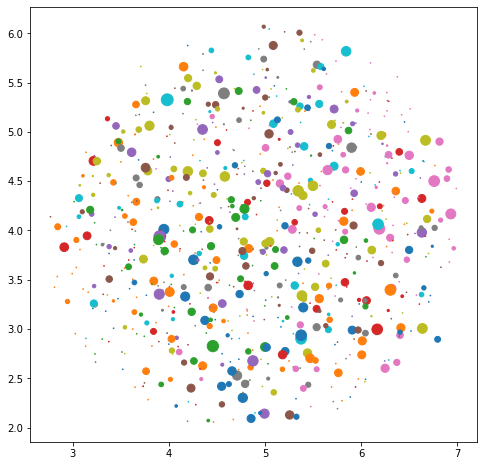

In [1308]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(activ)

i += 1
print(f"{i}/{len(dists)}")
plt.figure(figsize=(8,8))
plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=np.maximum(activ*50, 0.5), cmap="tab10")
# plt.scatter(embedding[:,0], embedding[:, 1], c=output_cent, s=activ, cmap="tab10")

In [1298]:
aa = dists.data.cpu()[i]
aa.mean(), aa.min(), aa.max(), aa.std()

(tensor(-2.1928e-07), tensor(-3.3969), tensor(3.0237), tensor(1.0006))

In [891]:
j = 0

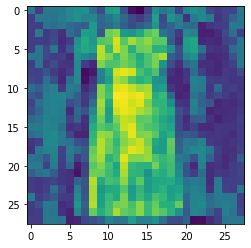

In [947]:
# plt.imshow(xx.cpu()[j].reshape(28,28))
plt.imshow(centers[j].reshape(28,28))
j += 1

## TSNE

In [948]:
from sklearn.manifold import TSNE

In [949]:
tsne = TSNE(n_components=2)
embt = tsne.fit_transform(centers)

In [950]:
embt

array([[-16.196321 , -22.545374 ],
       [-14.485771 ,  -9.562551 ],
       [  7.078476 ,  22.349606 ],
       ...,
       [ 16.037794 ,   2.6401882],
       [ -7.843508 , -11.150411 ],
       [ -5.4017816, -13.356525 ]], dtype=float32)

In [1006]:
i = 0

0/50


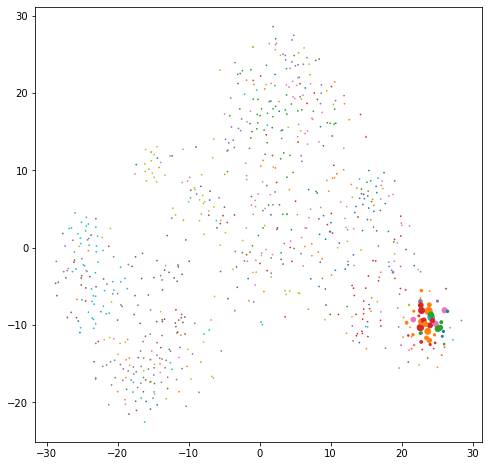

In [1007]:
activ = dists.data.cpu()[i]
# activ = activ - activ.min()
# activ = torch.exp(-activ)
print(f"{i}/{len(dists)}")
i += 1
plt.figure(figsize=(8,8))
# plt.scatter(embt[:,0], embt[:, 1], c=activ, marker=".")
plt.scatter(embt[:,0], embt[:, 1], c=output_cent, s=np.maximum(activ*50, 0.5), cmap="tab10")

### Data UMAP Visualization - Euclidean vs Cosine

In [49]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1)
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [50]:
centers = train_data.cpu().numpy()
lbls = train_label_

embedding = embed.fit_transform(centers)

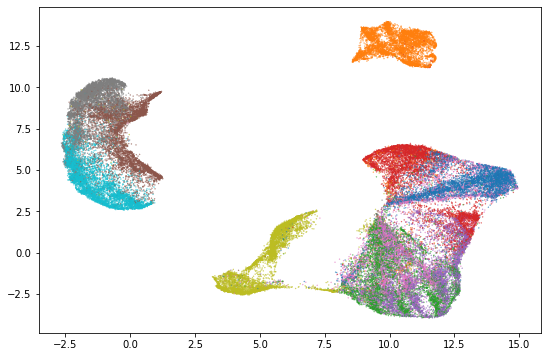

In [51]:
plt.figure(figsize=(9,6))
plt.scatter(embedding[:,0], embedding[:, 1], c=lbls, cmap="tab10", s=0.1)

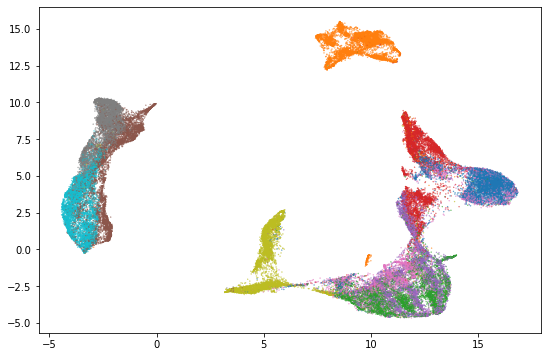

In [52]:
embed = umap.UMAP(n_neighbors=50, n_components=2, min_dist=0.1, spread=1, metric="cosine")
embedding = embed.fit_transform(centers)

plt.figure(figsize=(9,6))
plt.scatter(embedding[:,0], embedding[:, 1], c=lbls, cmap="tab10", s=0.1)